<p style="font-family: Arial; font-size:1.4em;color:gray;"> B2Metric Hiring Assesment </p> Metin Kerem ÜRKMEZ 

<span style='color:gray'> Home Credit Default Risk (https://www.kaggle.com/c/home-credit-default-risk) </span>

<span style='color:gray'> Challenge - Binary Classification on Large Dataset </span>

<p style="font-family: Arial; font-size:1.4em;color:gold;"> NOTEBOOK 1 </p>

### IMPORT REQUIRED LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import gc
import re
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import RidgeClassifier

import warnings
warnings.simplefilter('ignore')

### READ DATASETS + REDUCING MEMORY

In [2]:
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int32', 'int64', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,
                                                                                                           100*(start_mem-end_mem)/start_mem,
                                                                                                           (time.time()-starttime)/60))
    return df

In [3]:
df_application_train = pd.read_csv('application_train.csv')
reduce_mem(df_application_train)

-- Mem. usage decreased to 161.88 Mb (43.4% reduction),time spend:0.04 min


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_application_test = pd.read_csv('application_test.csv')
reduce_mem(df_application_test)

-- Mem. usage decreased to 25.47 Mb (43.4% reduction),time spend:0.01 min


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [5]:
df_bureau_balance = pd.read_csv('bureau_balance.csv')
reduce_mem(df_bureau_balance)

-- Mem. usage decreased to 416.56 Mb (33.3% reduction),time spend:0.01 min


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [6]:
df_bureau = pd.read_csv('bureau.csv')
reduce_mem(df_bureau)

-- Mem. usage decreased to 130.95 Mb (41.2% reduction),time spend:0.01 min


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,9.132300e+04,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,2.250000e+05,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,4.643235e+05,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,9.000000e+04,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2.700000e+06,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,1.125000e+04,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,3.813084e+04,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,1.557000e+04,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,3.600000e+04,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [7]:
df_installments_payments = pd.read_csv('installments_payments.csv')
reduce_mem(df_installments_payments)

-- Mem. usage decreased to 415.20 Mb (50.0% reduction),time spend:0.02 min


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500000,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500000,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.433594,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500000,NaN


In [8]:
df_credit_card_balance = pd.read_csv('credit_card_balance.csv')
reduce_mem(df_credit_card_balance)

-- Mem. usage decreased to 351.59 Mb (47.8% reduction),time spend:0.03 min


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000000,45000,NaN,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000000,45000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.968750,585000,270000.0,270000.0,0.0,0.0,2250.000000,...,273093.968750,273093.968750,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000000,450000,NaN,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,NaN,0,NaN,NaN,0.0,Active,0,0


In [9]:
df_POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
reduce_mem(df_POS_CASH_balance)

-- Mem. usage decreased to 343.37 Mb (43.7% reduction),time spend:0.01 min


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [10]:
df_previous_application = pd.read_csv('previous_application.csv')
reduce_mem(df_previous_application)

-- Mem. usage decreased to 337.68 Mb (28.4% reduction),time spend:0.01 min


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290039,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855469,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.519531,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


# <span style='color:blue'> PREPROCESSING </span>

### AGGREGATING ALL TABLES IN ONE DATASET, HANDLING CATEGORICAL VARIABLES AND DROPPING COLUMNS WITH VARIENCE LESS THAN 0.01 

*In [12 -> 65] code cells that between line markdowns are from https://www.kaggle.com/aantonova/aggregating-all-tables-in-one-dataset*

<span style='color:red'> Bahsi geçen kısım dışında(tabloların birleştirilmesi), 1. ve 2. notebook için diğer kaynaklardan kod çekilmemiştir. Çalışma özgündür. </span>

_______________________________________________________________________________________________________________________________

In [11]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
for c in df_application_train.columns[df_application_train.dtypes == 'object']:
    c_train = set(df_application_train[c].unique())
    c_test = set(df_application_test[c].unique())
    diff = c_train ^ c_test
    if len(diff) > 0:
        print('feature ' + c + ' has different values: ', diff)

feature CODE_GENDER has different values:  {'XNA'}
feature NAME_INCOME_TYPE has different values:  {'Maternity leave'}
feature NAME_FAMILY_STATUS has different values:  {'Unknown'}


In [14]:
df_application_train['CODE_GENDER'] = df_application_train['CODE_GENDER'] \
                                                        .map(lambda x: x if x != 'XNA' else np.nan)
df_application_train['NAME_INCOME_TYPE'] = df_application_train['NAME_INCOME_TYPE'] \
                                                        .map(lambda x: x if x != 'Maternity leave' else np.nan)
df_application_train['NAME_FAMILY_STATUS'] = df_application_train['NAME_FAMILY_STATUS'] \
                                                        .map(lambda x: x if x != 'Unknown' else np.nan)

In [15]:
for c in df_application_train.columns[df_application_train.dtypes == 'object']:
    d = df_application_train[c].value_counts()
    if df_application_train[c].nunique() == 2:
        d[0] = 0
        d[1] = 1
            
    df_application_train[c] = df_application_train[c].map(d)
    df_application_test[c] = df_application_test[c].map(d)

In [16]:
features_with_small_variance = df_application_train.columns[(df_application_train.std(axis = 0) < .01).values]
df_application_train[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
FLAG_MOBIL,307511.0,0.999997,0.001803,0.0,1.0,1.0,1.0,1.0
FLAG_DOCUMENT_2,307511.0,0.000042,0.006502,0.0,0.0,0.0,0.0,1.0
FLAG_DOCUMENT_4,307511.0,0.000081,0.009016,0.0,0.0,0.0,0.0,1.0
FLAG_DOCUMENT_10,307511.0,0.000023,0.004771,0.0,0.0,0.0,0.0,1.0
FLAG_DOCUMENT_12,307511.0,0.000007,0.002550,0.0,0.0,0.0,0.0,1.0


In [17]:
features_with_small_variance = df_application_test.columns[(df_application_test.std(axis = 0) < .01).values]
df_application_test[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
FLAG_MOBIL,48744.0,0.999979,0.004529,0.0,1.0,1.0,1.0,1.0
FLAG_DOCUMENT_2,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_7,48744.0,0.000041,0.006405,0.0,0.0,0.0,0.0,1.0
FLAG_DOCUMENT_10,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_12,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_13,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_14,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_15,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_16,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_17,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [18]:
df_application_train.drop(features_with_small_variance, axis = 1, inplace = True)
df_application_test.drop(features_with_small_variance, axis = 1, inplace = True)
print(df_application_train.shape, df_application_test.shape)

(307511, 109) (48744, 108)


In [19]:
df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [20]:
for val in df_bureau_balance['STATUS'].unique():
    df_bureau_balance['STATUS_' + val] = (df_bureau_balance['STATUS'] == val).map(int)

df_bureau_balance.drop('STATUS', axis = 1, inplace = True)
df_bureau_balance.head() 

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_C,STATUS_0,STATUS_X,STATUS_1,STATUS_2,STATUS_3,STATUS_5,STATUS_4
0,5715448,0,1,0,0,0,0,0,0,0
1,5715448,-1,1,0,0,0,0,0,0,0
2,5715448,-2,1,0,0,0,0,0,0,0
3,5715448,-3,1,0,0,0,0,0,0,0
4,5715448,-4,1,0,0,0,0,0,0,0


In [21]:
features_with_small_variance = df_bureau_balance.columns[(df_bureau_balance.std(axis = 0) < .01).values]
print(len(features_with_small_variance))

0


In [22]:
df_bureau_balance.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype
---  ------          --------------     -----
 0   SK_ID_BUREAU    27299925 non-null  int32
 1   MONTHS_BALANCE  27299925 non-null  int32
 2   STATUS_C        27299925 non-null  int64
 3   STATUS_0        27299925 non-null  int64
 4   STATUS_X        27299925 non-null  int64
 5   STATUS_1        27299925 non-null  int64
 6   STATUS_2        27299925 non-null  int64
 7   STATUS_3        27299925 non-null  int64
 8   STATUS_5        27299925 non-null  int64
 9   STATUS_4        27299925 non-null  int64
dtypes: int32(2), int64(8)
memory usage: 1.8 GB


In [23]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [24]:
for val in df_bureau['CREDIT_ACTIVE'].unique():
    df_bureau['CREDIT_ACTIVE_' + val] = (df_bureau['CREDIT_ACTIVE'] == val).map(int)
    
df_bureau.drop('CREDIT_ACTIVE', axis = 1, inplace = True)

In [25]:
for val in df_bureau['CREDIT_CURRENCY'].unique():
    df_bureau['CREDIT_CURRENCY_' + val] = (df_bureau['CREDIT_CURRENCY'] == val).map(int)
    
df_bureau.drop('CREDIT_CURRENCY', axis = 1, inplace = True)

In [26]:
for val in df_bureau['CREDIT_TYPE'].unique():
    df_bureau['CREDIT_TYPE_' + val] = (df_bureau['CREDIT_TYPE'] == val).map(int)
    
df_bureau.drop('CREDIT_TYPE', axis = 1, inplace = True)

In [27]:
features_with_small_variance = df_bureau.columns[(df_bureau.std(axis = 0) < .01).values]
print(len(features_with_small_variance))

8


In [28]:
df_bureau[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
CREDIT_ACTIVE_Bad debt,1716428.0,1.223471e-05,0.003498,0.0,0.0,0.0,0.0,1.0
CREDIT_CURRENCY_currency 4,1716428.0,5.826053e-06,0.002414,0.0,0.0,0.0,0.0,1.0
CREDIT_TYPE_Real estate loan,1716428.0,1.573034e-05,0.003966,0.0,0.0,0.0,0.0,1.0
CREDIT_TYPE_Cash loan (non-earmarked),1716428.0,3.262590e-05,0.005712,0.0,0.0,0.0,0.0,1.0
CREDIT_TYPE_Loan for the purchase of equipment,1716428.0,1.106950e-05,0.003327,0.0,0.0,0.0,0.0,1.0
CREDIT_TYPE_Mobile operator loan,1716428.0,5.826053e-07,0.000763,0.0,0.0,0.0,0.0,1.0
CREDIT_TYPE_Interbank credit,1716428.0,5.826053e-07,0.000763,0.0,0.0,0.0,0.0,1.0
CREDIT_TYPE_Loan for purchase of shares (margin lending),1716428.0,2.330421e-06,0.001527,0.0,0.0,0.0,0.0,1.0


In [29]:
df_bureau.drop(features_with_small_variance, axis = 1, inplace = True)
print(df_bureau.shape)

(1716428, 29)


In [30]:
df_bureau.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 29 columns):
 #   Column                                              Non-Null Count    Dtype  
---  ------                                              --------------    -----  
 0   SK_ID_CURR                                          1716428 non-null  int32  
 1   SK_ID_BUREAU                                        1716428 non-null  int32  
 2   DAYS_CREDIT                                         1716428 non-null  int32  
 3   CREDIT_DAY_OVERDUE                                  1716428 non-null  int32  
 4   DAYS_CREDIT_ENDDATE                                 1610875 non-null  float32
 5   DAYS_ENDDATE_FACT                                   1082775 non-null  float32
 6   AMT_CREDIT_MAX_OVERDUE                              591940 non-null   float32
 7   CNT_CREDIT_PROLONG                                  1716428 non-null  int32  
 8   AMT_CREDIT_SUM                                      

In [31]:
for c in df_bureau_balance.drop('SK_ID_BUREAU', axis = 1).columns:
    res = df_bureau_balance.groupby(by = 'SK_ID_BUREAU')[c].mean()
    df_bureau['Balance_' + str(c)] = df_bureau['SK_ID_BUREAU'] \
                                                        .map(lambda x: res[x] if x in res.index else np.nan)
        
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Another type of loan,Balance_MONTHS_BALANCE,Balance_STATUS_C,Balance_STATUS_0,Balance_STATUS_X,Balance_STATUS_1,Balance_STATUS_2,Balance_STATUS_3,Balance_STATUS_5,Balance_STATUS_4
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
features_with_small_variance = df_bureau.columns[(df_bureau.std(axis = 0) < .01).values]
print(len(features_with_small_variance))

3


In [33]:
df_bureau[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
Balance_STATUS_2,774354.0,0.000708,0.008136,0.0,0.0,0.0,0.0,0.714286
Balance_STATUS_3,774354.0,0.000244,0.003849,0.0,0.0,0.0,0.0,0.400000
Balance_STATUS_4,774354.0,0.000158,0.002921,0.0,0.0,0.0,0.0,0.500000


In [34]:
df_bureau.drop(features_with_small_variance, axis = 1, inplace = True)
print(df_bureau.shape)

(1716428, 35)


In [35]:
df_bureau.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 35 columns):
 #   Column                                              Non-Null Count    Dtype  
---  ------                                              --------------    -----  
 0   SK_ID_CURR                                          1716428 non-null  int32  
 1   SK_ID_BUREAU                                        1716428 non-null  int32  
 2   DAYS_CREDIT                                         1716428 non-null  int32  
 3   CREDIT_DAY_OVERDUE                                  1716428 non-null  int32  
 4   DAYS_CREDIT_ENDDATE                                 1610875 non-null  float32
 5   DAYS_ENDDATE_FACT                                   1082775 non-null  float32
 6   AMT_CREDIT_MAX_OVERDUE                              591940 non-null   float32
 7   CNT_CREDIT_PROLONG                                  1716428 non-null  int32  
 8   AMT_CREDIT_SUM                                      

In [36]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [37]:
features_with_small_variance = df_installments_payments.columns[(df_installments_payments.std(axis = 0) < .01).values]
print(len(features_with_small_variance))

0


In [38]:
df_installments_payments.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   SK_ID_PREV              13605401 non-null  int32  
 1   SK_ID_CURR              13605401 non-null  int32  
 2   NUM_INSTALMENT_VERSION  13605401 non-null  float32
 3   NUM_INSTALMENT_NUMBER   13605401 non-null  int32  
 4   DAYS_INSTALMENT         13605401 non-null  float32
 5   DAYS_ENTRY_PAYMENT      13602496 non-null  float32
 6   AMT_INSTALMENT          13605401 non-null  float32
 7   AMT_PAYMENT             13602496 non-null  float32
dtypes: float32(5), int32(3)
memory usage: 415.2 MB


In [39]:
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [40]:
for val in df_credit_card_balance['NAME_CONTRACT_STATUS'].unique():
    df_credit_card_balance['NAME_CONTRACT_STATUS_' + val] = (df_credit_card_balance['NAME_CONTRACT_STATUS'] == val).map(int)
    
df_credit_card_balance.drop('NAME_CONTRACT_STATUS', axis = 1, inplace = True)

In [41]:
features_with_small_variance = df_credit_card_balance.columns[(df_credit_card_balance.std(axis = 0) < .01).values]
print(len(features_with_small_variance))

2


In [42]:
df_credit_card_balance[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
NAME_CONTRACT_STATUS_Refused,3840312.0,0.000004,0.002104,0.0,0.0,0.0,0.0,1.0
NAME_CONTRACT_STATUS_Approved,3840312.0,0.000001,0.001141,0.0,0.0,0.0,0.0,1.0


In [43]:
df_credit_card_balance.drop(features_with_small_variance, axis = 1, inplace = True)
print(df_credit_card_balance.shape)

(3840312, 27)


In [44]:
df_credit_card_balance.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 27 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   SK_ID_PREV                          3840312 non-null  int32  
 1   SK_ID_CURR                          3840312 non-null  int32  
 2   MONTHS_BALANCE                      3840312 non-null  int32  
 3   AMT_BALANCE                         3840312 non-null  float32
 4   AMT_CREDIT_LIMIT_ACTUAL             3840312 non-null  int32  
 5   AMT_DRAWINGS_ATM_CURRENT            3090496 non-null  float32
 6   AMT_DRAWINGS_CURRENT                3840312 non-null  float32
 7   AMT_DRAWINGS_OTHER_CURRENT          3090496 non-null  float32
 8   AMT_DRAWINGS_POS_CURRENT            3090496 non-null  float32
 9   AMT_INST_MIN_REGULARITY             3535076 non-null  float32
 10  AMT_PAYMENT_CURRENT                 3072324 non-null  float32
 11  AMT_PAYMENT

In [45]:
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [46]:
for val in df_POS_CASH_balance['NAME_CONTRACT_STATUS'].unique():
    df_POS_CASH_balance['NAME_CONTRACT_STATUS_' + val] = (df_POS_CASH_balance['NAME_CONTRACT_STATUS'] == val).map(int)
    
df_POS_CASH_balance.drop('NAME_CONTRACT_STATUS', axis = 1, inplace = True)

In [47]:
features_with_small_variance = df_POS_CASH_balance.columns[(df_POS_CASH_balance.std(axis = 0) < .01).values]
print(len(features_with_small_variance))

3


In [48]:
df_POS_CASH_balance[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
NAME_CONTRACT_STATUS_Canceled,10001358.0,1.499796e-06,0.001225,0.0,0.0,0.0,0.0,1.0
NAME_CONTRACT_STATUS_XNA,10001358.0,1.999728e-07,0.000447,0.0,0.0,0.0,0.0,1.0
NAME_CONTRACT_STATUS_Amortized debt,10001358.0,6.359136e-05,0.007974,0.0,0.0,0.0,0.0,1.0


In [49]:
df_POS_CASH_balance.drop(features_with_small_variance, axis = 1, inplace = True)
print(df_POS_CASH_balance.shape)

(10001358, 13)


In [50]:
df_POS_CASH_balance.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 13 columns):
 #   Column                                      Non-Null Count     Dtype  
---  ------                                      --------------     -----  
 0   SK_ID_PREV                                  10001358 non-null  int32  
 1   SK_ID_CURR                                  10001358 non-null  int32  
 2   MONTHS_BALANCE                              10001358 non-null  int32  
 3   CNT_INSTALMENT                              9975287 non-null   float32
 4   CNT_INSTALMENT_FUTURE                       9975271 non-null   float32
 5   SK_DPD                                      10001358 non-null  int32  
 6   SK_DPD_DEF                                  10001358 non-null  int32  
 7   NAME_CONTRACT_STATUS_Active                 10001358 non-null  int64  
 8   NAME_CONTRACT_STATUS_Completed              10001358 non-null  int64  
 9   NAME_CONTRACT_STATUS_Signed                 

In [51]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
for c in df_previous_application.columns[df_previous_application.dtypes == 'object']:
    if df_previous_application[c].nunique() == 2:
        d = df_previous_application[c].value_counts()
        df_previous_application[c] = df_previous_application[c].map({d[0]: 0, d[1]: 1})
    else:        
        for val in df_previous_application[c].unique():
            df_previous_application[str(c) + '_' + str(val)] = (df_previous_application[c] == val).map(int)
        df_previous_application.drop(c, axis = 1, inplace = True)

In [53]:
features_with_small_variance = df_previous_application.columns[(df_previous_application.std(axis = 0) < .01).values]
print(len(features_with_small_variance))

12


In [54]:
df_previous_application[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
NAME_CASH_LOAN_PURPOSE_Buying a garage,1670214.0,8.142669e-05,0.009023,0.0,0.0,0.0,0.0,1.0
NAME_CASH_LOAN_PURPOSE_Hobby,1670214.0,3.292991e-05,0.005738,0.0,0.0,0.0,0.0,1.0
NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,1670214.0,8.980885e-06,0.002997,0.0,0.0,0.0,0.0,1.0
NAME_CASH_LOAN_PURPOSE_Money for a third person,1670214.0,1.496814e-05,0.003869,0.0,0.0,0.0,0.0,1.0
NAME_TYPE_SUITE_nan,1670214.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0
NAME_GOODS_CATEGORY_Education,1670214.0,6.406365e-05,0.008004,0.0,0.0,0.0,0.0,1.0
NAME_GOODS_CATEGORY_Insurance,1670214.0,3.831844e-05,0.006190,0.0,0.0,0.0,0.0,1.0
NAME_GOODS_CATEGORY_Additional Service,1670214.0,7.663689e-05,0.008754,0.0,0.0,0.0,0.0,1.0
NAME_GOODS_CATEGORY_Weapon,1670214.0,4.610188e-05,0.006790,0.0,0.0,0.0,0.0,1.0
NAME_GOODS_CATEGORY_Animals,1670214.0,5.987257e-07,0.000774,0.0,0.0,0.0,0.0,1.0


In [55]:
df_previous_application.drop(features_with_small_variance, axis = 1, inplace = True)
print(df_previous_application.shape)

(1670214, 153)


In [56]:
df_previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Columns: 153 entries, SK_ID_PREV to PRODUCT_COMBINATION_POS others without interest
dtypes: float32(15), float64(1), int32(6), int64(131)
memory usage: 1.8 GB


In [57]:
for c in df_installments_payments.drop(['SK_ID_PREV', 'SK_ID_CURR'], axis = 1).columns:
    res = df_installments_payments.groupby(by = 'SK_ID_PREV')[c].mean()
    df_previous_application['IP_' + c] = df_previous_application['SK_ID_PREV'] \
                                                            .map(lambda x: res[x] if x in res.index else np.nan)

df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,...,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,IP_NUM_INSTALMENT_VERSION,IP_NUM_INSTALMENT_NUMBER,IP_DAYS_INSTALMENT,IP_DAYS_ENTRY_PAYMENT,IP_AMT_INSTALMENT,IP_AMT_PAYMENT
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,15,NaN,1,...,0,0,0,0,2.000000,1.0,-42.0,-42.000000,17284.275391,17284.275391
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,11,NaN,1,...,0,0,0,0,1.000000,3.0,-74.0,-83.199997,25188.615234,25188.615234
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,11,NaN,1,...,0,0,0,0,1.000000,5.0,-151.0,-159.222229,15060.735352,15060.735352
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,7,NaN,1,...,0,0,0,0,1.090909,6.0,-332.0,-339.090912,51193.945312,51193.945312
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,9,NaN,1,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
for c in df_credit_card_balance.drop(['SK_ID_PREV', 'SK_ID_CURR'], axis = 1).columns:
    res = df_credit_card_balance.groupby(by = 'SK_ID_PREV')[c].mean()
    df_previous_application['CCB_' + c] = df_previous_application['SK_ID_PREV'] \
                                                            .map(lambda x: res[x] if x in res.index else np.nan)

df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,...,CCB_CNT_DRAWINGS_OTHER_CURRENT,CCB_CNT_DRAWINGS_POS_CURRENT,CCB_CNT_INSTALMENT_MATURE_CUM,CCB_SK_DPD,CCB_SK_DPD_DEF,CCB_NAME_CONTRACT_STATUS_Active,CCB_NAME_CONTRACT_STATUS_Completed,CCB_NAME_CONTRACT_STATUS_Demand,CCB_NAME_CONTRACT_STATUS_Signed,CCB_NAME_CONTRACT_STATUS_Sent proposal
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,15,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,11,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,11,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,7,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,9,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
for c in df_POS_CASH_balance.drop(['SK_ID_PREV', 'SK_ID_CURR'], axis = 1).columns:
    res = df_POS_CASH_balance.groupby(by = 'SK_ID_PREV')[c].mean()
    df_previous_application['POS_' + c] = df_previous_application['SK_ID_PREV'] \
                                                            .map(lambda x: res[x] if x in res.index else np.nan)

df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,...,POS_CNT_INSTALMENT,POS_CNT_INSTALMENT_FUTURE,POS_SK_DPD,POS_SK_DPD_DEF,POS_NAME_CONTRACT_STATUS_Active,POS_NAME_CONTRACT_STATUS_Completed,POS_NAME_CONTRACT_STATUS_Signed,POS_NAME_CONTRACT_STATUS_Approved,POS_NAME_CONTRACT_STATUS_Returned to the store,POS_NAME_CONTRACT_STATUS_Demand
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,15,NaN,1,...,6.500000,6.000000,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,11,NaN,1,...,36.000000,34.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,11,NaN,1,...,12.000000,7.500000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,7,NaN,1,...,11.916667,6.416667,0.0,0.0,0.916667,0.083333,0.0,0.0,0.0,0.0
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,9,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
%%time
for c in df_bureau.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis = 1).columns:
    res = df_bureau.groupby(by = 'SK_ID_CURR')[c].mean()
    df_application_train['Bureau_' + str(c)] = df_bureau['SK_ID_CURR'] \
                                                        .map(lambda x: res[x] if x in res.index else np.nan)
    df_application_test['Bureau_' + str(c)] = df_bureau['SK_ID_CURR'] \
                                                        .map(lambda x: res[x] if x in res.index else np.nan)

Wall time: 14min 44s


In [61]:
%%time
for c in df_previous_application.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis = 1).columns:
    res = df_previous_application.groupby(by = 'SK_ID_CURR')[c].mean()
    df_application_train['Prev_' + str(c)] = df_previous_application['SK_ID_CURR'] \
                                                        .map(lambda x: res[x] if x in res.index else np.nan)
    df_application_test['Prev_' + str(c)] = df_previous_application['SK_ID_CURR'] \
                                                        .map(lambda x: res[x] if x in res.index else np.nan)

Wall time: 1h 19min 20s


In [62]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,Prev_POS_CNT_INSTALMENT,Prev_POS_CNT_INSTALMENT_FUTURE,Prev_POS_SK_DPD,Prev_POS_SK_DPD_DEF,Prev_POS_NAME_CONTRACT_STATUS_Active,Prev_POS_NAME_CONTRACT_STATUS_Completed,Prev_POS_NAME_CONTRACT_STATUS_Signed,Prev_POS_NAME_CONTRACT_STATUS_Approved,Prev_POS_NAME_CONTRACT_STATUS_Returned to the store,Prev_POS_NAME_CONTRACT_STATUS_Demand
0,100002,1,0,1.0,0,0,0,202500.0,406597.5,24700.5,...,8.083333,6.500000,0.000000,0.000000,0.607143,0.321429,0.071429,0.0,0.0,0.0
1,100003,0,0,0.0,0,1,0,270000.0,1293502.5,35698.5,...,17.630769,14.497436,0.000000,0.000000,0.835897,0.164103,0.000000,0.0,0.0,0.0
2,100004,0,1,1.0,1,0,0,67500.0,135000.0,6750.0,...,8.500000,4.916667,0.000000,0.000000,0.916667,0.083333,0.000000,0.0,0.0,0.0
3,100006,0,0,0.0,0,0,0,135000.0,312682.5,29686.5,...,12.400253,6.796086,0.000000,0.000000,0.897162,0.087686,0.015152,0.0,0.0,0.0
4,100007,0,0,1.0,0,0,0,121500.0,513000.0,21865.5,...,11.333333,8.111111,0.126984,0.126984,0.884703,0.115297,0.000000,0.0,0.0,0.0


In [63]:
df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,Prev_POS_CNT_INSTALMENT,Prev_POS_CNT_INSTALMENT_FUTURE,Prev_POS_SK_DPD,Prev_POS_SK_DPD_DEF,Prev_POS_NAME_CONTRACT_STATUS_Active,Prev_POS_NAME_CONTRACT_STATUS_Completed,Prev_POS_NAME_CONTRACT_STATUS_Signed,Prev_POS_NAME_CONTRACT_STATUS_Approved,Prev_POS_NAME_CONTRACT_STATUS_Returned to the store,Prev_POS_NAME_CONTRACT_STATUS_Demand
0,100001,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,...,8.083333,6.500000,0.000000,0.000000,0.607143,0.321429,0.071429,0.0,0.0,0.0
1,100005,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,...,17.630769,14.497436,0.000000,0.000000,0.835897,0.164103,0.000000,0.0,0.0,0.0
2,100013,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,...,8.500000,4.916667,0.000000,0.000000,0.916667,0.083333,0.000000,0.0,0.0,0.0
3,100028,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,12.400253,6.796086,0.000000,0.000000,0.897162,0.087686,0.015152,0.0,0.0,0.0
4,100038,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,...,11.333333,8.111111,0.126984,0.126984,0.884703,0.115297,0.000000,0.0,0.0,0.0


In [64]:
print(df_application_train.shape, df_application_test.shape)

(307511, 335) (48744, 334)


_______________________________________________________________________________________________________________________________

In [65]:
df = df_application_train.copy()
df_holdout = df_application_test.copy()

-> `df_application_test` have no target value. so I'm naming it as holdout instead of test. 
It can be used to generate submission.csv

In [66]:
reduce_mem(df)

-- Mem. usage decreased to 394.15 Mb (41.8% reduction),time spend:0.33 min


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,Prev_POS_CNT_INSTALMENT,Prev_POS_CNT_INSTALMENT_FUTURE,Prev_POS_SK_DPD,Prev_POS_SK_DPD_DEF,Prev_POS_NAME_CONTRACT_STATUS_Active,Prev_POS_NAME_CONTRACT_STATUS_Completed,Prev_POS_NAME_CONTRACT_STATUS_Signed,Prev_POS_NAME_CONTRACT_STATUS_Approved,Prev_POS_NAME_CONTRACT_STATUS_Returned to the store,Prev_POS_NAME_CONTRACT_STATUS_Demand
0,100002,1,0,1.0,0,0,0,202500.0,406597.5,24700.5,...,8.083334,6.500000,0.000000,0.000000,0.607143,0.321429,0.071429,0.0,0.0,0.0
1,100003,0,0,0.0,0,1,0,270000.0,1293502.5,35698.5,...,17.630770,14.497436,0.000000,0.000000,0.835897,0.164103,0.000000,0.0,0.0,0.0
2,100004,0,1,1.0,1,0,0,67500.0,135000.0,6750.0,...,8.500000,4.916667,0.000000,0.000000,0.916667,0.083333,0.000000,0.0,0.0,0.0
3,100006,0,0,0.0,0,0,0,135000.0,312682.5,29686.5,...,12.400252,6.796086,0.000000,0.000000,0.897162,0.087686,0.015152,0.0,0.0,0.0
4,100007,0,0,1.0,0,0,0,121500.0,513000.0,21865.5,...,11.333333,8.111111,0.126984,0.126984,0.884703,0.115297,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,1.0,0,1,0,157500.0,254700.0,27558.0,...,33.880951,30.047619,0.000000,0.000000,0.785714,0.214286,0.000000,0.0,0.0,0.0
307507,456252,0,0,0.0,0,0,0,72000.0,269550.0,12001.5,...,17.283550,10.781231,0.000000,0.000000,0.947181,0.052819,0.000000,0.0,0.0,0.0
307508,456253,0,0,0.0,0,0,0,153000.0,677664.0,29979.0,...,18.969929,9.969927,0.000000,0.000000,0.980797,0.019203,0.000000,0.0,0.0,0.0
307509,456254,1,0,0.0,0,0,0,171000.0,370107.0,20205.0,...,14.431580,8.957894,0.000000,0.000000,0.873684,0.126316,0.000000,0.0,0.0,0.0


In [67]:
reduce_mem(df_holdout)

-- Mem. usage decreased to 62.29 Mb (41.8% reduction),time spend:0.06 min


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,Prev_POS_CNT_INSTALMENT,Prev_POS_CNT_INSTALMENT_FUTURE,Prev_POS_SK_DPD,Prev_POS_SK_DPD_DEF,Prev_POS_NAME_CONTRACT_STATUS_Active,Prev_POS_NAME_CONTRACT_STATUS_Completed,Prev_POS_NAME_CONTRACT_STATUS_Signed,Prev_POS_NAME_CONTRACT_STATUS_Approved,Prev_POS_NAME_CONTRACT_STATUS_Returned to the store,Prev_POS_NAME_CONTRACT_STATUS_Demand
0,100001,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,...,8.083334,6.500000,0.000000,0.000000,0.607143,0.321429,0.071429,0.0,0.000000,0.0
1,100005,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,...,17.630770,14.497436,0.000000,0.000000,0.835897,0.164103,0.000000,0.0,0.000000,0.0
2,100013,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,...,8.500000,4.916667,0.000000,0.000000,0.916667,0.083333,0.000000,0.0,0.000000,0.0
3,100028,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,12.400252,6.796086,0.000000,0.000000,0.897162,0.087686,0.015152,0.0,0.000000,0.0
4,100038,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,...,11.333333,8.111111,0.126984,0.126984,0.884703,0.115297,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,0,0,0,0,121500.0,412560.0,17473.5,270000.0,...,4.000000,2.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0
48740,456222,0,0,0,1,2,157500.0,622413.0,31909.5,495000.0,...,12.000000,12.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0
48741,456223,0,0,1,0,1,202500.0,315000.0,33205.5,315000.0,...,10.592592,7.425926,0.000000,0.000000,0.907407,0.037037,0.000000,0.0,0.055556,0.0
48742,456224,0,1,0,1,0,225000.0,450000.0,25128.0,450000.0,...,12.925000,7.675000,0.000000,0.000000,0.925000,0.075000,0.000000,0.0,0.000000,0.0


-> sometimes upcasting can happen while performing dataset operations, so I call reduce_mem function again.

In [68]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 335 columns):
 #    Column                                                            Non-Null Count   Dtype  
---   ------                                                            --------------   -----  
 0    SK_ID_CURR                                                        307511 non-null  int32  
 1    TARGET                                                            307511 non-null  int32  
 2    NAME_CONTRACT_TYPE                                                307511 non-null  int32  
 3    CODE_GENDER                                                       307507 non-null  float32
 4    FLAG_OWN_CAR                                                      307511 non-null  int32  
 5    FLAG_OWN_REALTY                                                   307511 non-null  int32  
 6    CNT_CHILDREN                                                      307511 non-null  int32  
 7    AMT_INCOM

In [69]:
df.drop('Prev_FLAG_LAST_APPL_PER_CONTRACT', axis=1, inplace=True)

-> `Prev_FLAG_LAST_APPL_PER_CONTRACT` is full of nan

In [70]:
df.dropna(axis=0, how='all', inplace=True)

# <span style='color:blue'> EDA </span>

-> it is passed briefly because it is not very necessary for the purpose

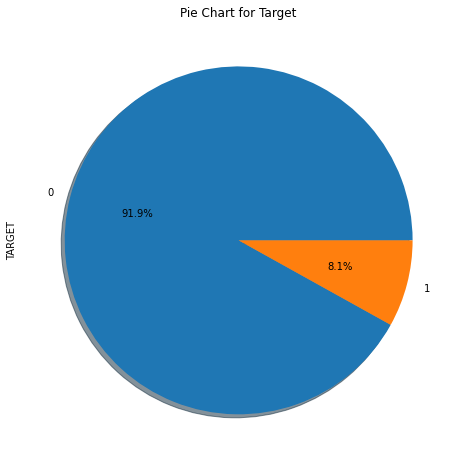

In [71]:
df['TARGET'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, figsize=(8,8))
plt.title('Pie Chart for Target')
plt.show()

-> imbalanced. something will be done

In [72]:
df.filter(regex='^Prev_', axis=1).nunique().sort_values(ascending = False).head(5) 

Prev_IP_AMT_PAYMENT           180020
Prev_IP_AMT_INSTALMENT        179883
Prev_AMT_ANNUITY              176680
Prev_IP_DAYS_ENTRY_PAYMENT    165593
Prev_AMT_CREDIT               160155
dtype: int64

In [73]:
cols_toplot = ['Prev_AMT_CREDIT','Prev_IP_DAYS_ENTRY_PAYMENT','Prev_AMT_ANNUITY','Prev_IP_AMT_INSTALMENT','Prev_IP_AMT_PAYMENT']

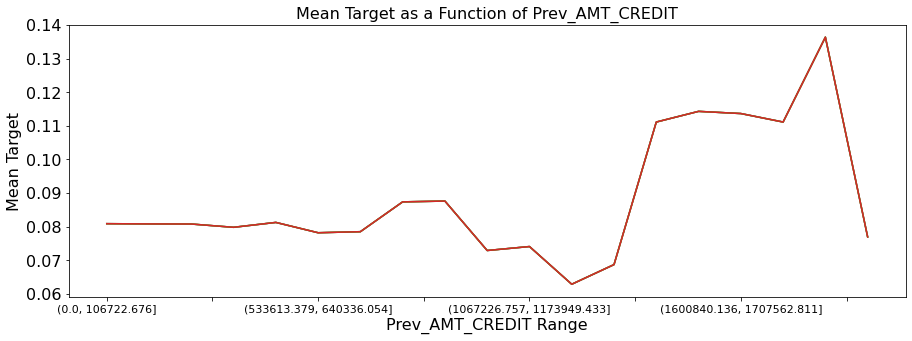

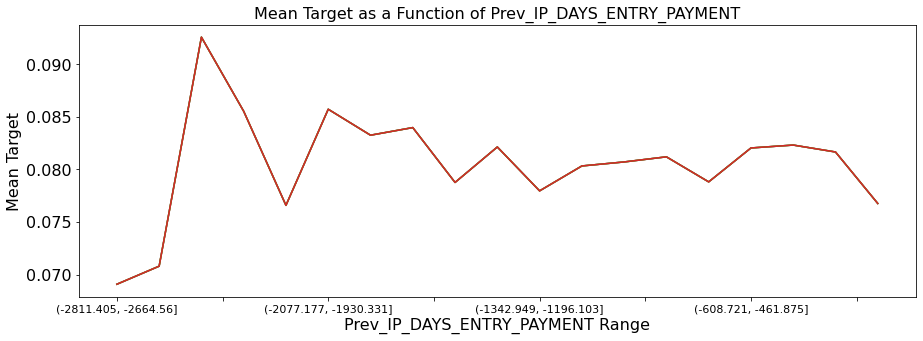

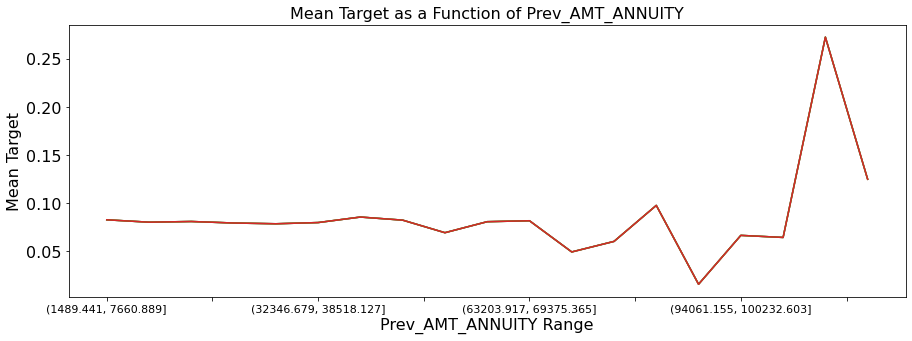

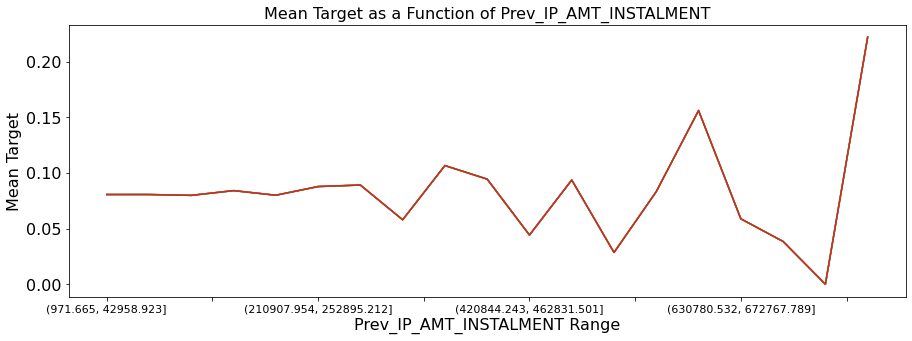

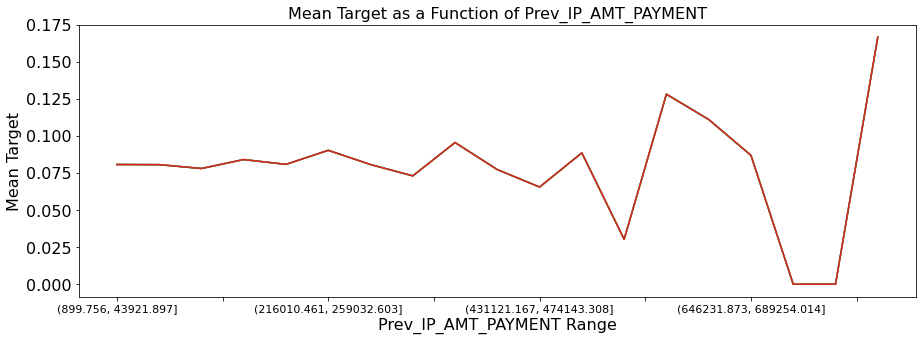

In [74]:
for factor in cols_toplot:
    factorMin = df[factor].quantile(q=0.0001)
    factorMax = df[factor].quantile(q=0.9999)
    plt.subplots(figsize=(15,5))
    for s in np.arange(1,5):
        df["TARGET"].groupby(pd.cut(df[factor], np.linspace(factorMin,factorMax,num=20))).mean().plot()
        plt.title("Mean Target as a Function of " + factor, fontsize=16)
        plt.xlabel(factor + " Range", fontsize=16)
        plt.ylabel("Mean Target", fontsize=16)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=16)

In [75]:
del df_application_train
del df_application_test
del df_bureau_balance
del df_bureau
del df_installments_payments
del df_credit_card_balance
del df_POS_CASH_balance
del df_previous_application

gc.collect()

17363

-> memory efficiency

In [76]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_holdout = df_holdout.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [77]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']                 

In [78]:
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [79]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

-> it makes sense to use StratifiedKFold as the imbalanced distribution is seen

In [80]:
clf_lgbm = lgb.LGBMClassifier()

cross_val_score(clf_lgbm, X_train_lgbm, y_train_lgbm, cv=folds, scoring='roc_auc')

array([0.75455274, 0.74432675, 0.75299693, 0.7534369 , 0.74454875])

# <span style='color:blue'> PREPROCESSING - </span> HANDLING MISSING VALUES

-> lightgbm can handle missing values. but to use ridgeclassifier, missing data must be filled

In [81]:
def dataframeInformations(df):
  totalEntryList=[]
  totalMissingValueList=[]
  missingValRateList=[]
  dataTypeList=[]
  uniqueValuesList=[]
  totalUniqueValList=[]
  variableNameList=[]
  
  for element in df.columns:
    missingValRate=round((df[element].isna().sum()/len(df[element]))*100,2) #to show correct decimal and float part of number.
    totalEntryList.append(len(df[element]))
    totalMissingValueList.append(df[element].isna().sum())
    missingValRateList.append(missingValRate)
    dataTypeList.append(df[element].dtype)
    uniqueValuesList.append(list(df[element].unique()))
    totalUniqueValList.append(len(df[element].unique()))
    variableNameList.append(element)
  #create a dataframe to show all informations together
  dataInfoDf=pd.DataFrame({'Variable':variableNameList,'#_Total_Entry':totalEntryList,\
                           '#_Missing_Value':totalMissingValueList,'%_Missing_Value':missingValRateList,\
                           'Data_Type':dataTypeList,'Unique_Values':uniqueValuesList,\
                           '#_Uniques_Values':totalUniqueValList})
  return dataInfoDf.sort_values(by="Variable")

In [82]:
df_desc = dataframeInformations(X_train_ridge)
df_desc

,Variable,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values
8,AMT_ANNUITY,215257,8,0.00,float32,"[67072.5, 25407.0, 27679.5, 9000.0, 37390.5, 7...",12848
7,AMT_CREDIT,215257,0,0.00,float32,"[706410.0, 545040.0, 942300.0, 180000.0, 72979...",5076
9,AMT_GOODS_PRICE,215257,199,0.09,float32,"[679500.0, 450000.0, 675000.0, 180000.0, 63000...",827
6,AMT_INCOME_TOTAL,215257,0,0.00,float32,"[157500.0, 121500.0, 225000.0, 144000.0, 11250...",1983
103,AMT_REQ_CREDIT_BUREAU_DAY,215257,29150,13.54,float32,"[0.0, nan, 1.0, 2.0, 3.0, 4.0, 6.0, 5.0, 9.0]",9
...,...,...,...,...,...,...,...
72,YEARS_BEGINEXPLUATATION_MEDI,215257,104989,48.77,float32,"[nan, 0.9856, 0.9791, 0.9871, 0.9965, 0.9906, ...",230
58,YEARS_BEGINEXPLUATATION_MODE,215257,104989,48.77,float32,"[nan, 0.9856, 0.9791, 0.9871, 0.9965, 0.9906, ...",208
45,YEARS_BUILD_AVG,215257,143139,66.50,float32,"[nan, 0.7144, 0.864, 0.9524, 0.6464, 0.7484, 0...",147
73,YEARS_BUILD_MEDI,215257,143139,66.50,float32,"[nan, 0.7182, 0.8658, 0.953, 0.6511, 0.7518, 0...",149


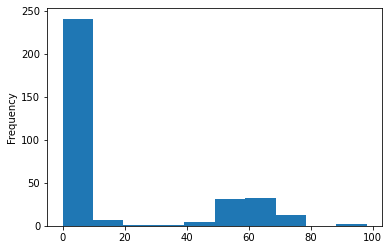

In [83]:
df_desc['%_Missing_Value'].plot.hist();

In [84]:
"""
imp = IterativeImputer(initial_strategy='median', max_iter = 5, n_nearest_features = 50)

imp.fit_transform(X_train_ridge)
imp.transform(X_test_ridge)
"""

"\nimp = IterativeImputer(initial_strategy='median', max_iter = 5, n_nearest_features = 50)\n\nimp.fit_transform(X_train_ridge)\nimp.transform(X_test_ridge)\n"

-> there are too many missing values. therefore, it is necessary to prefer complex imputing methods, but at this point, my memory error prevents complex imputing(KNN or MICE), so I wrote it as a comment

-> That being the case, I don't think using simple imputation methods would be better than lightgbm native solutions. for now i am not filling in missing data for lightgbm pipeline. but for the ridge pipeline, I filled the missing value with median

In [85]:
X_train_ridge_fillmedian = X_train_ridge.fillna(X_train_ridge.median(), inplace=False)
X_test_ridge_fillmedian = X_test_ridge.fillna(X_train_ridge.median(), inplace=False)

In [86]:
X_train_ridge_fillmedian_dropped = X_train_ridge_fillmedian.drop(df_desc[df_desc['%_Missing_Value'] > 80]['Variable'].values ,axis=1)

In [87]:
clf_ridge = RidgeClassifier()

cross_val_score(clf_ridge, X_train_ridge_fillmedian, y_train_ridge, cv=folds, scoring='roc_auc')

array([0.74333066, 0.73479043, 0.74308408, 0.74529354, 0.73432158])

In [88]:
cross_val_score(clf_ridge, X_train_ridge_fillmedian_dropped, y_train_ridge, cv=folds, scoring='roc_auc')

array([0.74333618, 0.73480528, 0.74312834, 0.74535668, 0.734351  ])

-> we get the same score when columns with more than 80% missing data are dropped or not. so let's drop it

In [89]:
X_test_ridge_fillmedian_dropped = X_test_ridge_fillmedian.drop(df_desc[df_desc['%_Missing_Value'] > 80]['Variable'].values ,axis=1)

In [90]:
del X_train_ridge_fillmedian
del X_test_ridge_fillmedian

gc.collect()

3354

-> even if I used garbage, the preprocessing stages filled the memory too much. I am getting an out of memory error. I will save the updated csvs and proceed on second notebook.

In [91]:
X_train_ridge_fillmedian_dropped.to_csv('X_train_ridge_fillmedian_dropped.csv',index=False)
X_test_ridge_fillmedian_dropped.to_csv('X_test_ridge_fillmedian_dropped.csv',index=False)
y_train_ridge.to_csv('y_train_ridge.csv',index=False)
y_test_ridge.to_csv('y_test_ridge.csv',index=False)

In [92]:
X_train_lgbm.to_csv('X_train_lgbm.csv',index=False)
X_test_lgbm.to_csv('X_test_lgbm.csv',index=False)
y_train_lgbm.to_csv('y_train_lgbm.csv',index=False)
y_test_lgbm.to_csv('y_test_lgbm.csv',index=False)

df_holdout.to_csv('df_holdout.csv',index=False)